Tx elements: 4, Rx elements: 8
Raw virtual elements (Nt*Nr): 32
Unique virtual positions: 11
First few virtual x-positions: [-0.00975 -0.0078  -0.00585 -0.0039  -0.00195  0.       0.00195  0.0039
  0.00585  0.0078 ]


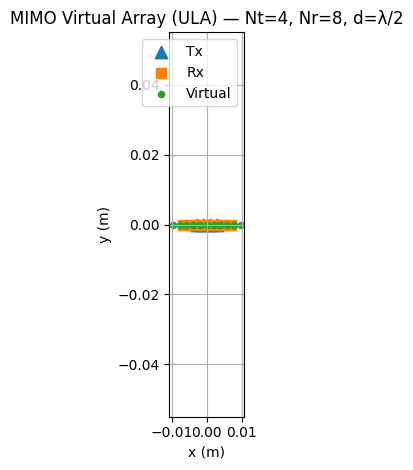

In [2]:
# MIMO virtual array visualization utilities + example
# This cell (1) defines reusable functions, (2) plots an example 1D ULA virtual array,
# and (3) saves a ready-to-use script at /mnt/data/mimo_virtual_array.py .
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def make_linear_array(n, d, axis="x", origin=0.0):
    """
    Create coordinates for a 1D uniform linear array (ULA).
    n: number of elements
    d: spacing (same unit as wavelength if you want d=λ/2, etc.)
    axis: 'x' or 'y'
    origin: center position (coordinate at the array center)
    Returns: (n, 2) array of [x, y] coordinates (2D for easy plotting)
    """
    idx = np.arange(n) - (n - 1) / 2.0
    coords = np.zeros((n, 2), dtype=float)
    if axis.lower() == "x":
        coords[:, 0] = origin + idx * d
    else:
        coords[:, 1] = origin + idx * d
    return coords

def make_grid_array(nx, ny, dx, dy, origin=(0.0, 0.0)):
    """
    Create coordinates for a 2D uniform planar array (UPA).
    nx, ny: number of elements along x and y
    dx, dy: spacing along x and y
    origin: (x0, y0) at the grid center
    Returns: (nx*ny, 2) array of [x, y] coords
    """
    ix = np.arange(nx) - (nx - 1) / 2.0
    iy = np.arange(ny) - (ny - 1) / 2.0
    X, Y = np.meshgrid(ix * dx, iy * dy, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1)
    pts[:, 0] += origin[0]
    pts[:, 1] += origin[1]
    return pts

def virtual_array_positions(tx, rx):
    """
    Compute virtual array positions for MIMO radar.
    tx: (Nt, D) Tx element coordinates (D=2 for 2D plotting; can be 3 as well)
    rx: (Nr, D) Rx element coordinates
    Returns: (Nt*Nr, D) array of virtual positions = tx_i + rx_j
    """
    tx = np.atleast_2d(tx)
    rx = np.atleast_2d(rx)
    virt = (tx[:, None, :] + rx[None, :, :]).reshape(-1, tx.shape[1])
    return virt

def deduplicate_positions(pts, tol=1e-9):
    """
    Merge duplicate (or numerically close) positions with tolerance 'tol' (in same unit as coordinates).
    Returns unique points and an index map to the unique set.
    """
    # Round to grid defined by tol for robust uniqueness
    key = np.round(pts / tol).astype(np.int64)
    _, idx_unique = np.unique(key, axis=0, return_index=True)
    unique = pts[np.sort(idx_unique)]
    # map each point to its unique index (optional)
    # Build KD-free map via dictionary on rounded keys
    # This returns indices corresponding to unique array positions for each original point
    key_to_u = {tuple(k): i for i, k in enumerate(key[np.sort(idx_unique)])}
    map_idx = np.array([key_to_u[tuple(k)] for k in key])
    return unique, map_idx

def plot_arrays(tx, rx, virt, title="MIMO Virtual Array (2D)"):
    """
    Scatter-plot Tx, Rx, and virtual array positions on a 2D plane.
    - One figure, no subplots (per instructions).
    - Distinct markers; colors left to matplotlib defaults.
    """
    plt.figure()
    # 2D enforcement: if 1D provided, pad y=0
    def to2d(a):
        a = np.atleast_2d(a)
        if a.shape[1] == 1:
            return np.concatenate([a, np.zeros((a.shape[0], 1))], axis=1)
        return a[:, :2]
    tx2 = to2d(tx)
    rx2 = to2d(rx)
    v2 = to2d(virt)

    plt.scatter(tx2[:, 0], tx2[:, 1], marker="^", s=80, label="Tx")
    plt.scatter(rx2[:, 0], rx2[:, 1], marker="s", s=60, label="Rx")
    plt.scatter(v2[:, 0], v2[:, 1], marker="o", s=20, label="Virtual")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===== Example 1: 1D ULA (typical TDM-MIMO) =====
# Choose wavelength= 3.9 mm (≈ 77 GHz) → use d = λ/2 by default
lam = 0.0039
d = lam / 2.0

Nt, Nr = 4, 8  # e.g., 4 Tx, 8 Rx

# Tx along x, centered at 0; Rx along x, centered at 0
tx = make_linear_array(Nt, d, axis="x", origin=0.0)
rx = make_linear_array(Nr, d, axis="x", origin=0.0)

virt = virtual_array_positions(tx, rx)
virt_unique, _ = deduplicate_positions(virt, tol=1e-9)

print(f"Tx elements: {Nt}, Rx elements: {Nr}")
print(f"Raw virtual elements (Nt*Nr): {virt.shape[0]}")
print(f"Unique virtual positions: {virt_unique.shape[0]}")
print("First few virtual x-positions:", np.round(virt_unique[:10,0], 6))

plot_arrays(tx, rx, virt_unique, title=f"MIMO Virtual Array (ULA) — Nt={Nt}, Nr={Nr}, d=λ/2")

# ===== Save a reusable script =====
script = r'''#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

def make_linear_array(n, d, axis="x", origin=0.0):
    idx = np.arange(n) - (n - 1) / 2.0
    coords = np.zeros((n, 2), dtype=float)
    if axis.lower() == "x":
        coords[:, 0] = origin + idx * d
    else:
        coords[:, 1] = origin + idx * d
    return coords

def make_grid_array(nx, ny, dx, dy, origin=(0.0, 0.0)):
    ix = np.arange(nx) - (nx - 1) / 2.0
    iy = np.arange(ny) - (ny - 1) / 2.0
    X, Y = np.meshgrid(ix * dx, iy * dy, indexing="xy")
    pts = np.stack([X.ravel(), Y.ravel()], axis=1)
    pts[:, 0] += origin[0]
    pts[:, 1] += origin[1]
    return pts

def virtual_array_positions(tx, rx):
    tx = np.atleast_2d(tx)
    rx = np.atleast_2d(rx)
    virt = (tx[:, None, :] + rx[None, :, :]).reshape(-1, tx.shape[1])
    return virt

def deduplicate_positions(pts, tol=1e-9):
    key = np.round(pts / tol).astype(np.int64)
    _, idx_unique = np.unique(key, axis=0, return_index=True)
    unique = pts[np.sort(idx_unique)]
    key_to_u = {tuple(k): i for i, k in enumerate(key[np.sort(idx_unique)])}
    map_idx = np.array([key_to_u[tuple(k)] for k in key])
    return unique, map_idx

def plot_arrays(tx, rx, virt, title="MIMO Virtual Array (2D)"):
    plt.figure()
    def to2d(a):
        a = np.atleast_2d(a)
        if a.shape[1] == 1:
            return np.concatenate([a, np.zeros((a.shape[0], 1))], axis=1)
        return a[:, :2]
    tx2 = to2d(tx)
    rx2 = to2d(rx)
    v2 = to2d(virt)

    plt.scatter(tx2[:, 0], tx2[:, 1], marker="^", s=80, label="Tx")
    plt.scatter(rx2[:, 0], rx2[:, 1], marker="s", s=60, label="Rx")
    plt.scatter(v2[:, 0], v2[:, 1], marker="o", s=20, label="Virtual")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example: 77 GHz → λ ≈ 3.9 mm; d = λ/2
    lam = 0.0039
    d = lam / 2.0
    Nt, Nr = 4, 8

    tx = make_linear_array(Nt, d, axis="x", origin=0.0)
    rx = make_linear_array(Nr, d, axis="x", origin=0.0)

    virt = virtual_array_positions(tx, rx)
    virt_unique, _ = deduplicate_positions(virt, tol=1e-9)

    print(f"Tx elements: {Nt}, Rx elements: {Nr}")
    print(f"Raw virtual elements (Nt*Nr): {virt.shape[0]}")
    print(f"Unique virtual positions: {virt_unique.shape[0]}")

    plot_arrays(tx, rx, virt_unique, title=f"MIMO Virtual Array (ULA) — Nt={Nt}, Nr={Nr}, d=λ/2")
'''

